# Behavioral data analysis

### Imports

In [1]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from copy import deepcopy
import copy

import pygsp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.utils import resample
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simpson
from scipy.stats import boxcox
from sklearn.metrics import auc


from scipy.stats import pearsonr

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading EEG data and data from questionnaires. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [2]:
# paths TODO
dir_path = os.path.dirname(os.path.abspath(""))

In [3]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256
random_state = 0

In [4]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600_sonata/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*GNG-(\d+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename, dtype={'Demo_kod': object})
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info, dtype={'Demo_kod': object})
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )      
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    # event_dict = {
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
    #     "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
    #     "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
    #     "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
    #     "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    # }
    
    event_dict = {
        'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10003,
        'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10004,
        'Stimulus/RE*ex*1_n*1_c_2*R': 10005,
        'Stimulus/RE*ex*1_n*2_c_1*R': 10006,
        'Stimulus/RE*ex*2_n*1_c_1*R': 10007,
        'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10008,
        'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10009,
        'Stimulus/RE*ex*2_n*2_c_2*R': 10010,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10003, 10004, 10008, 10009],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10005, 10006, 10007, 10010],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = False
    
    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    ar = AutoReject(random_state=random_state, n_jobs=10, verbose=0)
    epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
    
    return epochs_ar

#### Read the data

In [7]:
def change_column_names(data_df):
    columns_dict = {
        "Demo_kod": "ID",
        "16-Rumination Full Scale": "RRQ", # mean
        "05-DASS-21 Anxiety scale": "DASS-21 Anx", # mean
        ###
        "05-DASS-21 Stress scale": "DASS-21 Stress", # mean
        "05-DASS-21 Depression scale": "DASS-21 Dep", # mean
        "04-STAI Trait MEAN": "STAI-T_M", # mean
        "04-STAI STATE 1-2 DIFFERENCE": "STAI-S Diff", # sum
        "number_error" : "uninhibited response", # sum
        "number_inhibited" : "inhibited response", # sum
        ###
        "04-STAI Trait SUM": "STAI-T", # sum
        "07-BIS": "BIS", # mean
        "14-Obsessive-Compulsive WASHING": "WASH", # mean
        "14-Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "14-Obsessive-Compulsive HOARDING": "HOARD", # mean
        "14-Obsessive-Compulsive ORDERING": "ORD", # mean
        "14-Obsessive-Compulsive CHECKING": "CHECK", # mean
        "14-Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        # "14-Obsessive-Compulsive FULL": "OCI-R",
        "18-Thought Suppression Inventory": "WBSI", # mean
        "28-Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "06-Self-Esteem Scale_SES Rosenberga": "SES", # mean
        "07-BAS Dzialanie": 'BAS_D', # mean
        "07-BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean
        "07-BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean
        "22-Nonforgiveness - Full Scale": 'NONFOR',
        "27-Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "03-SP (Punishment Sensitivity)": 'PUN', # sum
        "03-SR (Reward Sensitivity)": 'REW', # sum
        "15-Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "15-Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "15-Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        "17-Perfectionism CMDA": 'CMDA', # mean
        "17-Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "19-Guilt sensitivity": 'G_SE', # mean
        "31-NFC Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "31-NFC Preferowanie przewidywalności-FULL": 'PRED', # mean
        "32-High standards from Maximization Full Scale" : 'STAND',   # mean
        "Wiek": "Age",
        "Płeć": "Sex",
        "Ręczność": "Handness",    

        #######
        "Rumination Full Scale": "RRQ",
        "DASS-21 Anxiety scale 0-SUM": "DASS-21 Anx", # sum
        "DASS-21 Stress scale 0-SUM": "DASS-21 Stress", # sum
        "DASS-21 Depression scale 0-SUM": "DASS-21 Dep", # sum
        "number_error": "uninhibited response", # sum
        "number_inhibited":  "inhibited response", # sum
        "STAI STATE 1-2 DIFFERENCE": "STAI-S Diff", # sum
        ###
        "STAI Trait SUM": "STAI-T", # sum
        "BIS": "BIS", # mean
        "Obsessive-Compulsive WASHING": "WASH", # mean
        "Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "Obsessive-Compulsive HOARDING": "HOARD", # mean
        "Obsessive-Compulsive ORDERING": "ORD", # mean
        "Obsessive-Compulsive CHECKING": "CHECK", # mean
        "Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        # "14-Obsessive-Compulsive FULL": "OCI-R",
        "Thought Suppression Inventory": "WBSI", # mean
        "Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "Self-Esteem Scale_SES Rosenberga MEAN": "SES", # mean
        "BAS Dzialanie": 'BAS_D', # mean # drive
        "BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean # fun seeking
        "BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean # responsivness
        # "22-Nonforgiveness - Full Scale": 'NONFOR',
        "Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "SP (Punishment Sensitivity)": 'PUN', # sum
        "SR (Reward Sensitivity)": 'REW', # sum
        "Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        # "17-Perfectionism CMDA": 'CMDA',
        "Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "Guilt sensitivity": 'G_SE', # mean
        "Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "Preferowanie przewidywalności-FULL": 'PRED', # mean
        "High standards from Maximization Full Scale" : 'STAND',   # mean
    }

    data_df = data_df.rename(columns=columns_dict)
    return data_df

- read Study 1 train data

In [8]:
# %%capture
df_name = "GNG_autoreject_3_5"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_opus_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    # save loaded data into a pickle file
    epochs_train_opus_df.to_pickle("../data/" + epochs_train_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [9]:
epochs_train_opus_df.shape

(110, 188)

In [10]:
epochs_train_opus_df['STAI-T'] = epochs_train_opus_df['STAI-T'].apply(lambda x: x/20)

- read Study 2 train data

In [11]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_stai"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_sonata_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    # save loaded data into a pickle file
    epochs_train_sonata_df.to_pickle("../data/" + epochs_train_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [12]:
epochs_train_sonata_df.shape

(150, 110)

Refine some data from questionnaries to reconcile data from two datasets

In [13]:
epochs_train_sonata_df.loc[epochs_train_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [14]:
# normalize DASS-21 subscales scores to mean
epochs_train_sonata_df['DASS-21 Stress'] = epochs_train_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Anx'] = epochs_train_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Dep'] = epochs_train_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [15]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_train_sonata_df['STAI-T'] = epochs_train_sonata_df['STAI-T'].apply(lambda x: x/20)

In [16]:
# fill missing value in STAI-S Diff score
epochs_train_sonata_df.loc[epochs_train_sonata_df['STAI-S Diff'] == 'None', 'STAI-S Diff'] = None
epochs_train_sonata_df['STAI-S Diff'] = np.array(epochs_train_sonata_df['STAI-S Diff'].to_list()).astype(np.float) 

In [17]:
epochs_train_sonata_df['STAI-S Diff'] = epochs_train_sonata_df['STAI-S Diff'].fillna(epochs_train_sonata_df['STAI-S Diff'].mean())

#### Read data for external testing

- read Study 1 test

In [18]:
# %%capture
df_name = "GNG_autoreject_3_5_test_performance"
pickled_data_filename = "../data/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_opus_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    # save loaded data into a pickle file
    epochs_test_opus_df.to_pickle("../data/" + epochs_test_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [19]:
epochs_test_opus_df.shape

(45, 164)

In [20]:
epochs_test_opus_df['STAI-T'] = epochs_test_opus_df['STAI-T'].apply(lambda x: x/20)

- read Study 2 test

In [21]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_test_stai"
pickled_data_filename = "../data/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_sonata_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    # save loaded data into a pickle file
    epochs_test_sonata_df.to_pickle("../data/" + epochs_test_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [22]:
epochs_test_sonata_df.shape

(67, 110)

Refine some data from questionnaries to reconcile data from two datasets

In [23]:
epochs_test_sonata_df.loc[epochs_test_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [24]:
# normalize DASS-21 subscales scores to mean
epochs_test_sonata_df['DASS-21 Stress'] = epochs_test_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Anx'] = epochs_test_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Dep'] = epochs_test_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [25]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_test_sonata_df['STAI-T'] = epochs_test_sonata_df['STAI-T'].apply(lambda x: x/20)

In [26]:
# fill missing value in STAI-S Diff score
epochs_test_sonata_df.loc[epochs_test_sonata_df['STAI-S Diff'] == 'None', 'STAI-S Diff'] = None
epochs_test_sonata_df['STAI-S Diff'] = np.array(epochs_test_sonata_df['STAI-S Diff'].to_list()).astype(np.float) 

In [27]:
epochs_test_sonata_df['STAI-S Diff'] = epochs_test_sonata_df['STAI-S Diff'].fillna(epochs_test_sonata_df['STAI-S Diff'].mean())

## Merge dataframes

In [28]:
opus_columns_list = epochs_train_opus_df.columns.to_list()
sonata_columns_list = epochs_train_sonata_df.columns.to_list()

columns = list(set(opus_columns_list) & set(sonata_columns_list))

In [29]:
epochs_train_sonata_df = epochs_train_sonata_df[columns]
epochs_train_opus_df = epochs_train_opus_df[columns]

epochs_test_sonata_df = epochs_test_sonata_df[columns]
epochs_test_opus_df = epochs_test_opus_df[columns]

Create train and test data

In [30]:
epochs_train_df = pd.concat([epochs_train_sonata_df, epochs_train_opus_df], ignore_index=True)
epochs_test_df = pd.concat([epochs_test_sonata_df, epochs_test_opus_df], ignore_index=True)

## Basic sample info

In [31]:
data_df = pd.concat([epochs_train_df, epochs_test_df], ignore_index=True)
data_df["Sex"] = pd.to_numeric(data_df["Sex"])
data_df.describe()

,PRED,WASH,REW,IUS-P,Handness,CHECK,PUN,DASS-21 Dep,DASS-21 Anx,IUS-I,...,STAI-T,ORD,SES,G_SE,Age,OB_PERF,uninhibited response,WBSI,BIS,HARM
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,...,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,371.000000,372.000000,372.000000,372.000000
mean,3.667527,1.665511,4.161290,3.150941,0.913978,2.557348,6.099462,1.916863,1.736164,2.454301,...,2.265457,2.475869,2.815591,3.007527,23.303763,3.397312,30.199461,3.535950,3.013925,3.966129
std,0.872423,0.802311,2.044203,0.758802,0.280773,1.053152,3.607913,0.685878,0.571525,0.928238,...,0.466170,1.094560,0.629272,0.764895,3.984023,1.261195,15.129106,0.797191,0.530974,1.002978
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.250000,1.000000,1.000000,1.200000,18.000000,1.000000,2.000000,1.266667,1.290000,1.000000
25%,3.097500,1.000000,3.000000,2.675357,1.000000,1.670000,3.000000,1.428571,1.285714,1.800000,...,1.900000,1.666667,2.400000,2.500000,21.000000,2.400000,19.000000,3.000000,2.675000,3.400000
50%,3.630000,1.333333,4.000000,3.142857,1.000000,2.333333,6.000000,1.714286,1.710000,2.400000,...,2.250000,2.333333,2.800000,3.000000,22.000000,3.400000,28.000000,3.600000,3.000000,4.000000
75%,4.250000,2.000000,6.000000,3.711071,1.000000,3.333333,9.000000,2.290000,2.140000,3.200000,...,2.600000,3.330000,3.300000,3.600000,25.000000,4.250000,39.000000,4.130000,3.400000,4.600000
max,6.000000,4.670000,8.000000,5.000000,1.000000,5.000000,13.000000,4.000000,3.428571,5.000000,...,3.500000,5.000000,4.000000,4.900000,40.000000,6.800000,89.000000,5.000000,4.000000,6.800000


In [32]:
data_df["Sex"].value_counts()

0.0    218
1.0    153
0.5      1
Name: Sex, dtype: int64

## Behavioral data

In [33]:
stats_opus_df = pd.read_csv("../data/behavioral/stats_opus.csv", dtype={'ID': object})
stats_sonata_df = pd.read_csv("../data/behavioral/stats_sonata.csv", dtype={'ID': object})

stats_df = pd.concat([stats_opus_df, stats_sonata_df], ignore_index=True)

In [34]:
ID_train_list = epochs_train_df.id.to_list()
ID_test_list = epochs_test_df.id.to_list()

In [35]:
train_df = stats_df[stats_df['ID'].isin(ID_train_list)]
test_df = stats_df[stats_df['ID'].isin(ID_test_list)]

### The train dataset stats

Extract RT of correct and error trials

In [36]:
error_rt = train_df["mean_error_RT"].to_numpy()
correct_rt = train_df["mean_hit_RT"].to_numpy()
error_trials_num = train_df["number_error"].to_numpy()
correct_trials_num = train_df["number_fast_hit"].to_numpy() + train_df["number_slow_hit"].to_numpy()

In [37]:
print(f"X train average number of:\n erroneous responses: {error_trials_num.mean()} SD = {error_trials_num.std()}\n correct responses: {correct_trials_num.mean()} SD = {correct_trials_num.std()}")

X train average number of:
 erroneous responses: 30.753846153846155 SD = 15.050715055060973
 correct responses: 222.0423076923077 SD = 5.002512682252258


In [38]:
print(f"X train average RT for:\n erroneous responses: {error_rt.mean()} SD = {error_rt.std()}\n correct responses: {correct_rt.mean()} SD = {correct_rt.std()}")

X train average RT for:
 erroneous responses: 0.27030590995437886 SD = 0.03998336172077024
 correct responses: 0.31391902709942004 SD = 0.03839498623165998


In [39]:
t_value, p_value = scipy.stats.ttest_rel(error_rt, correct_rt)
print(f"t({train_df.shape[0] -1}) = {t_value}, p = {p_value}")

t(259) = -30.02478893659167, p = 2.515311128658282e-86


Average number of trials included in the analysis

In [40]:
error_len = epochs_train_df['epoch'].map(lambda x: len(x['error_response'].get_data())).to_numpy()
correct_len = epochs_train_df['epoch'].map(lambda x: len(x['correct_response'].get_data())).to_numpy()

In [41]:
print(f"AVG number of incorrect responses in the train set: {np.mean(error_len)} (SD={np.std(error_len)})")
print(f"AVG number of correct responses in the train set: {np.mean(correct_len)} (SD={np.std(correct_len)})")

AVG number of incorrect responses in the train set: 26.4 (SD=14.87569002924415)
AVG number of correct responses in the train set: 208.39615384615385 (SD=16.816680838913186)


Average performnce

In [42]:
train_df['performance'] = train_df['number_inhibited'] / (train_df['number_inhibited'] + train_df['number_error'])
performance = train_df['performance'].to_numpy()

In [43]:
print(f"AVG performance in the test set: {np.mean(performance)} (SD={np.std(performance)})")

AVG performance in the test set: 0.7254120879120878 (SD=0.13438138442018727)


### The test dataset stats

Extract RT of correct and error trials

In [44]:
error_rt = test_df["mean_error_RT"].to_numpy()
correct_rt = test_df["mean_hit_RT"].to_numpy()
error_trials_num = test_df["number_error"].to_numpy()
correct_trials_num = test_df["number_fast_hit"].to_numpy() + test_df["number_slow_hit"].to_numpy()

In [45]:
print(f"X test average number of:\n erroneous responses: {error_trials_num.mean()} SD = {error_trials_num.std()}\n correct responses: {correct_trials_num.mean()} SD = {correct_trials_num.std()}")

X test average number of:
 erroneous responses: 29.8125 SD = 15.05734944541796
 correct responses: 221.17857142857142 SD = 12.580607444534202


In [46]:
print(f"X test average RT for:\n erroneous responses: {error_rt.mean()} SD = {error_rt.std()}\n correct responses: {correct_rt.mean()} SD = {correct_rt.std()}")

X test average RT for:
 erroneous responses: 0.279543690458374 SD = 0.05006774091343918
 correct responses: 0.31690101267004345 SD = 0.038402111817197285


In [47]:
scipy.stats.ttest_rel(error_rt, correct_rt)

TtestResult(statistic=-14.371290376563417, pvalue=4.322410935846735e-27, df=111)

Average number of trials included in the analusis

In [48]:
error_len = epochs_test_df['epoch'].map(lambda x: len(x['error_response'].get_data())).to_numpy()
correct_len = epochs_test_df['epoch'].map(lambda x: len(x['correct_response'].get_data())).to_numpy()

In [49]:
print(f"AVG number of incorrect responses in the test set: {np.mean(error_len)} (SD={np.std(error_len)})")
print(f"AVG number of correct responses in the test set: {np.mean(correct_len)} (SD={np.std(correct_len)})")

AVG number of incorrect responses in the test set: 25.857142857142858 (SD=14.057825186691995)
AVG number of correct responses in the test set: 211.10714285714286 (SD=17.906182662729105)


Average performnce

In [50]:
test_df['performance'] = test_df['number_inhibited'] / (test_df['number_inhibited'] + test_df['number_error'])
performance = test_df['performance'].to_numpy()

In [51]:
print(f"AVG performance in the test set: {np.mean(performance)} (SD={np.std(performance)})")

AVG performance in the test set: 0.7338169642857143 (SD=0.13444062004837465)


## EEG features

### Amplitude

In [52]:
roi = [
    "Fz", 
]

In [53]:
ern_pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("mean_amplitude", AverageSignal()),
    
])

crn_pipeline = Pipeline([
   ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked(condition='correct_response')),
    ('extract_averaged_data', ExtractData()),
    ("mean_amplitude", AverageSignal()),
    
])

- training set

Difference in the 0-100 ms window between conditions

In [54]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_train_df.to_dict()))

preprocessed_X_ern_train = ern_pipeline.fit_transform(epochs_df_copy)

(260, 1, 27)


In [55]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_train_df.to_dict()))

preprocessed_X_crn_train = crn_pipeline.fit_transform(epochs_df_copy)

(260, 1, 27)


In [56]:
print(f"AVG ERN amplitude in the test set: {np.mean(preprocessed_X_ern_train*1000000)} (SD={np.std(preprocessed_X_ern_train*1000000)})")
print(f"AVG CRN amplitude in the test set: {np.mean(preprocessed_X_crn_train*1000000)} (SD={np.std(preprocessed_X_crn_train*1000000)})")

AVG ERN amplitude in the test set: -3.8639573451838625 (SD=4.488426820942082)
AVG CRN amplitude in the test set: 1.082688271461599 (SD=3.989177511236276)


In [57]:
scipy.stats.ttest_rel(preprocessed_X_ern_train, preprocessed_X_crn_train)

TtestResult(statistic=array([-20.0781833]), pvalue=array([1.02666958e-54]), df=array([259]))

- testing set

Difference in the 0-100 ms window between conditions

In [58]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_test_df.to_dict()))

preprocessed_X_ern_test = ern_pipeline.fit_transform(epochs_df_copy)

(112, 1, 27)


In [59]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_test_df.to_dict()))

preprocessed_X_crn_test = crn_pipeline.fit_transform(epochs_df_copy)

(112, 1, 27)


In [60]:
print(f"AVG ERN amplitude in the test set: {np.mean(preprocessed_X_ern_test*1000000)} (SD={np.std(preprocessed_X_ern_test*1000000)})")
print(f"AVG CRN amplitude in the test set: {np.mean(preprocessed_X_crn_test*1000000)} (SD={np.std(preprocessed_X_crn_test*1000000)})")

AVG ERN amplitude in the test set: -4.201507466851092 (SD=4.886520290525054)
AVG CRN amplitude in the test set: 0.7144537049557085 (SD=3.8413251814587124)


In [61]:
scipy.stats.ttest_rel(preprocessed_X_ern_test, preprocessed_X_crn_test)

TtestResult(statistic=array([-11.96174502]), pvalue=array([1.09473106e-21]), df=array([111]))

#### Difference between training and testing sets in amplitudes of ERN and CRN

In [62]:
scipy.stats.ttest_ind(preprocessed_X_ern_train, preprocessed_X_ern_test)

Ttest_indResult(statistic=array([0.64582078]), pvalue=array([0.51879575]))

In [63]:
scipy.stats.ttest_ind(preprocessed_X_crn_train, preprocessed_X_crn_test)

Ttest_indResult(statistic=array([0.82357677]), pvalue=array([0.41071061]))

## Questionnaries, Covariates, and ERPs descriptive stats

In [104]:
test = True
dataset = 'test' if test else 'train'
epochs_df = epochs_test_df if test else epochs_train_df

ERN

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [105]:
roi = [
    "Fz", 
]

In [106]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

ern_pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("mean_amplitude", AverageSignal()),
    
]).fit(epochs_df_copy)

preprocessed_X_ern = ern_pipeline.transform(epochs_df_copy)
preprocessed_X_ern = preprocessed_X_ern.reshape(preprocessed_X_ern.shape[0], -1)

(112, 1, 27)
(112, 1, 27)


In [107]:
preprocessed_X_ern.shape

(112, 1)

CRN

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [108]:
roi = [
    "Fz", 
]

In [109]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

crn_pipeline = Pipeline([
   ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked(condition='correct_response')),
    ('extract_averaged_data', ExtractData()),
    ("mean_amplitude", AverageSignal()),
    
]).fit(epochs_df_copy)

preprocessed_X_crn = crn_pipeline.transform(epochs_df_copy)
preprocessed_X_crn = preprocessed_X_crn.reshape(preprocessed_X_crn.shape[0], -1)

(112, 1, 27)
(112, 1, 27)


In [110]:
preprocessed_X_crn.shape

(112, 1)

Fractional area latency - ERN

In [111]:
def fractional_negative_area_latency(evoked, fraction=0.5, tmin=0.0, tmax=0.5, threshold = 0.0):
    subject_data = evoked.get_data()
    x = np.linspace(tmin, tmax, subject_data.shape[-1])
    # print(x)
    y = subject_data.flatten()
    
    # get only negative part of signal
    y_negative = [abs(y_item) if y_item < threshold else 0 for y_item in y]
    
    # calculate area under the signal
    area = abs(simpson(y_negative, x))
    
    if area != 0.0:
        fractional_area = area * fraction
    
        # search for latency point (x) which split area according to fraction provided 
        current_area = 0
        fractional_area_index = 0
        i = 2
        while abs(simpson(y_negative[:i], x[:i])) <= fractional_area:
            current_area = abs(simpson(y_negative[:i], x[:i]))
            fractional_area_index = i
            i+=1
            
        # print(f'{fractional_area_index}; {x[fractional_area_index]}')
        # print(x)
        
        return (fractional_area_index, x[fractional_area_index])    
    else:
        print('No area detected')
        return (None, None) 

Parameters

In [112]:
roi = ['Fz']
tmin = -0.05
tmax = 0.2
threshold = 1*1e-6

Estimate fractional area latency

In [113]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [114]:
X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
    ("average", Evoked(condition='error_response')),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

In [115]:
fractional_latencies = []
for i in range(0, len(X)):        
    subject = X[i][0]
    evoked = subject
    # print(f"Index: {i}")
    this_latency = fractional_negative_area_latency(evoked, fraction=0.5, tmin=tmin, tmax=tmax, threshold=threshold)
    fractional_latencies.append(this_latency)

In [116]:
fractional_latencies_ern = list(map(lambda x: x[1] ,fractional_latencies))
fractional_latencies_ern = np.array(fractional_latencies_ern).reshape(-1,1)
fractional_latencies_ern.shape

(112, 1)

Fractional area latency - CRN

Parameters: threshold at $2 \mu V$

In [117]:
roi = ['Fz']
tmin = -0.05
tmax = 0.2
threshold = 2*1e-6 # przy tym thresholdzie nie lapiemy wszystkich osob 1= 7 os; 2 = wszyscy

Estimate fractional area latency

In [118]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [119]:
X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
    ("average", Evoked(condition='correct_response')),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

In [120]:
fractional_latencies = []
for i in range(0, len(X)):        
    subject = X[i][0]
    evoked = subject
    # print(f"Index: {i}")
    this_latency = fractional_negative_area_latency(evoked, fraction=0.5, tmin=tmin, tmax=tmax, threshold=threshold)
    fractional_latencies.append(this_latency)

No area detected


In [121]:
fractional_latencies_crn_2uV = list(map(lambda x: x[1] ,fractional_latencies))
fractional_latencies_crn_2uV = np.array(fractional_latencies_crn_2uV).reshape(-1,1)
fractional_latencies_crn_2uV.shape

(112, 1)

---

#### Extract anxiety-related questionnaires scores

Questionnaires to include in analysis

In [122]:
rumination = "RRQ"
dass_anxiety = "DASS-21 Anx"
dass_stress = "DASS-21 Stress"
dass_dep = "DASS-21 Dep"
stai_t = "STAI-T" 
stai_s_diff = "STAI-S Diff" 
uninhibited_responses = "uninhibited response"
inhibited_responses = "inhibited response"
bis = "BIS"
bas_dzialanie = "BAS_D"
bas_przyjemnosc = "BAS_PRZY"
bas_nagroda = "BAS_NAG"
washing = "WASH"
obsessing = "OBSESS"
hoarding = "HOARD"
ordering = "ORD"
checking = "CHECK"
neutralizing = "NEU"
oci_r_full = "OCI-R"
threat = "OT"
thought_suppression = "WBSI"
indecisivness = "INDEC_F"
IU_prospecitve = "IUS-P"
IU_inhibitory = "IUS-I"
self_esteem = "SES"
punishment_sensitivity = "PUN"
reward_sensitivity = "REW"
harm_responsibility = "HARM"
thought_control = "T-CTR"
perfectionism_IU = "OB_PERF"
# perfectionism_cmda = "17-Perfectionism CMDA"
perfectionism_ps = "PS"
guilt_sensitivity = "G_SE"
intolerance_ambiguity = "AMB"
predictability = "PRED"
high_standards = "STAND"

In [123]:
scales = [
    rumination,
    # dass_anxiety,
    dass_stress,
    dass_dep,
    stai_t,
    stai_s_diff,
    uninhibited_responses,
    inhibited_responses,
    bis,
    bas_dzialanie,
    bas_przyjemnosc,
    bas_nagroda,
    washing,
    obsessing,
    hoarding,
    ordering,
    checking,
    neutralizing,
    # oci_r_full,
    threat,
    thought_suppression,
    indecisivness,
    punishment_sensitivity,
    reward_sensitivity,
    harm_responsibility,
    guilt_sensitivity,
    thought_control,
    perfectionism_IU,
    # perfectionism_cmda,
    perfectionism_ps,
    intolerance_ambiguity,
    predictability,
    high_standards,
    IU_prospecitve,
    IU_inhibitory,
    self_esteem,
]

In [124]:
questionnaires_scores_df = epochs_df[scales]
questionnaires_scores_df

,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,STAI-S Diff,uninhibited response,inhibited response,BIS,BAS_D,BAS_PRZY,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
0,4.250000,1.714286,1.428571,2.35,8.0,28.0,84.0,3.40,4.00,3.00,...,3.9,3.2,5.2,3.285714,4.00,4.63,5.333333,3.428571,2.0,3.0
1,2.500000,1.714286,2.142857,2.00,9.0,45.0,67.0,3.10,1.75,2.50,...,2.4,3.4,3.4,1.571429,4.50,3.63,2.666667,2.857143,2.0,2.5
2,4.166667,2.285714,3.142857,2.90,14.0,17.0,95.0,3.10,2.00,3.00,...,4.0,3.0,4.0,2.714286,4.50,4.00,3.666667,3.000000,3.2,1.6
3,2.250000,2.428571,1.857143,1.95,6.0,31.0,81.0,2.70,3.00,2.50,...,2.9,3.4,2.2,4.285714,3.67,2.25,6.000000,3.571429,1.8,3.4
4,2.416667,1.857143,1.142857,1.75,-1.0,11.0,101.0,3.00,2.50,2.50,...,2.5,1.0,2.0,3.142857,4.00,2.63,5.333333,2.571429,1.2,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,4.250000,2.710000,2.570000,3.05,-1.0,10.0,102.0,4.00,3.50,2.25,...,4.2,4.6,5.2,3.570000,4.83,2.75,4.670000,2.860000,4.2,2.4
108,2.500000,3.000000,2.140000,2.55,2.0,26.0,86.0,3.14,1.50,1.50,...,3.9,2.0,4.6,2.710000,4.00,3.25,3.330000,3.710000,2.6,2.2
109,3.250000,2.430000,1.710000,2.50,-2.0,22.0,90.0,2.71,3.00,2.75,...,3.1,3.6,3.8,4.000000,3.50,3.25,6.330000,3.000000,3.0,3.6
110,1.920000,2.140000,1.710000,1.65,0.0,29.0,83.0,2.71,1.75,2.50,...,3.2,2.2,2.4,2.290000,3.17,3.63,3.670000,2.710000,1.4,3.4


Fill missing value from external file - TODO to automatisation

In [125]:
questionnaires_scores_df[questionnaires_scores_df.isna().any(axis=1)]

,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,STAI-S Diff,uninhibited response,inhibited response,BIS,BAS_D,BAS_PRZY,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES
102,4.08,2.43,2.0,2.4,-2.0,NaN,NaN,3.57,2.75,3.25,...,4.1,2.8,2.8,1.71,4.5,4.63,4.0,4.0,3.8,3.7


In [126]:
if test:
    questionnaires_scores_df.at[102, 'uninhibited response'] = 14.0
    questionnaires_scores_df.at[102, 'inhibited response'] = 98.0
else:
    print('None to fill')

In [127]:
questionnaires_scores_df[questionnaires_scores_df.isna().any(axis=1)]

,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,STAI-S Diff,uninhibited response,inhibited response,BIS,BAS_D,BAS_PRZY,...,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES


Create performance metric based on inhibited and uninhibited responses

In [128]:
questionnaires_scores_df['performance'] = questionnaires_scores_df['inhibited response'] / questionnaires_scores_df['uninhibited response']
questionnaires_scores_df = questionnaires_scores_df.drop(columns=['inhibited response', 'uninhibited response'])

Inspect data

In [129]:
questionnaires_scores_df[questionnaires_scores_df.isna().any(axis=1)]

,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,STAI-S Diff,BIS,BAS_D,BAS_PRZY,BAS_NAG,WASH,...,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES,performance


In [130]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
    display(questionnaires_scores_df.describe())

,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,STAI-S Diff,BIS,BAS_D,BAS_PRZY,BAS_NAG,WASH,OBSESS,HOARD,ORD,CHECK,NEU,OT,WBSI,INDEC_F,PUN,REW,HARM,G_SE,T-CTR,OB_PERF,PS,AMB,PRED,STAND,IUS-P,IUS-I,SES,performance
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,3.542411,2.208202,1.855612,2.237054,4.053571,3.003661,2.455357,2.774554,3.226786,1.672262,2.422381,2.056518,2.461458,2.577530,1.487738,2.808929,3.488899,3.091845,5.946429,4.464286,3.996429,3.068750,2.412500,3.373214,3.137806,4.148839,3.607232,4.517798,3.211684,2.405357,2.846429,3.893995
std,0.895835,0.649908,0.654062,0.458343,6.726095,0.551110,0.630685,0.559480,0.426590,0.754135,0.987241,0.898047,1.137774,1.066730,0.716969,1.165383,0.776863,0.773604,3.704974,1.990647,1.001614,0.743746,1.002081,1.275831,0.876994,0.798313,0.822479,1.115602,0.706690,0.913348,0.629304,3.074056
min,1.083333,1.000000,1.000000,1.300000,-11.000000,1.290000,1.000000,1.250000,1.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.330000,1.270000,0.000000,0.000000,2.000000,1.200000,1.000000,1.000000,1.285714,2.500000,1.880000,2.000000,1.285714,1.000000,1.400000,0.365854
25%,2.833333,1.714286,1.290000,1.900000,-0.250000,2.600000,2.000000,2.500000,3.000000,1.000000,1.666667,1.330000,1.583333,1.670000,1.000000,2.000000,3.000000,2.533333,3.000000,3.000000,3.400000,2.600000,1.600000,2.400000,2.430000,3.670000,3.097500,4.000000,2.714286,1.800000,2.475000,1.800000
50%,3.831667,2.214286,1.714286,2.200000,3.000000,3.000000,2.500000,2.750000,3.200000,1.333333,2.330000,2.000000,2.330000,2.333333,1.330000,2.800000,3.533333,3.131667,6.000000,5.000000,3.800000,3.100000,2.200000,3.400000,3.285714,4.000000,3.500000,4.666667,3.142857,2.400000,2.900000,2.862069
75%,4.250000,2.606071,2.142857,2.512500,8.000000,3.430000,2.750000,3.000000,3.600000,2.000000,3.000000,2.666667,3.333333,3.333333,1.670000,3.400000,4.000000,3.616667,9.000000,6.000000,4.600000,3.625000,3.050000,4.200000,3.714286,4.670000,4.032500,5.330000,3.571429,3.000000,3.300000,4.976608
max,4.920000,4.000000,3.714286,3.450000,30.000000,4.000000,4.000000,4.000000,4.000000,4.670000,5.000000,4.670000,5.000000,5.000000,5.000000,5.800000,5.000000,4.733333,13.000000,8.000000,6.800000,4.500000,5.200000,6.600000,4.860000,6.000000,5.630000,7.000000,5.000000,5.000000,4.000000,15.000000


#### Demographical data

In [131]:
age = "Age"
sex = "Sex"
handness = "Handness"

In [132]:
scales = [
    age,
    # sex,
    handness
]

In [133]:
demographical_scores_df =  epochs_df[scales].astype(float)
demographical_scores_df = demographical_scores_df.rename(columns={'Handness': 'Handedness'})

In [134]:
demographical_scores_df.describe()

,Age,Handedness
count,112.000000,112.000000
mean,23.517857,0.937500
std,3.995453,0.243149
min,18.000000,0.000000
25%,21.000000,1.000000
50%,22.000000,1.000000
75%,25.000000,1.000000
max,38.000000,1.000000


In [135]:
# demographical_scores_df['Sex'].value_counts()

#### Concatenate questionnaire, covariates, and EEG features

In [136]:
if test:
    fractional_latencies_crn_2uV[fractional_latencies_crn_2uV == None] = np.nan
    fractional_latencies_crn_2uV_df = pd.DataFrame(fractional_latencies_crn_2uV)
    fractional_latencies_crn_2uV_df.fillna(value = np.nanmean(fractional_latencies_crn_2uV), inplace=True)
    fractional_latencies_crn_2uV = fractional_latencies_crn_2uV_df.to_numpy()

In [137]:
results_df = pd.DataFrame()

eeg_features_df = pd.DataFrame({
    'ERN' : preprocessed_X_ern.flatten() * 1000000,
    'ERN lat' : fractional_latencies_ern.flatten() * 1000,
    'CRN' : preprocessed_X_crn.flatten() * 1000000,
    'CRN lat' : fractional_latencies_crn_2uV.flatten() * 1000,

    
})

results_df = pd.concat([questionnaires_scores_df, demographical_scores_df, eeg_features_df], axis=1)
# results_df.to_pickle(f"../data/behavioral/all_variables_{dataset}.pkl")
results_df.head()

,RRQ,DASS-21 Stress,DASS-21 Dep,STAI-T,STAI-S Diff,BIS,BAS_D,BAS_PRZY,BAS_NAG,WASH,...,IUS-P,IUS-I,SES,performance,Age,Handedness,ERN,ERN lat,CRN,CRN lat
0,4.250000,1.714286,1.428571,2.35,8.0,3.4,4.00,3.0,3.8,1.666667,...,3.428571,2.0,3.0,3.000000,24.0,1.0,1.910689,-7.03125,2.215947,0.78125
1,2.500000,1.714286,2.142857,2.00,9.0,3.1,1.75,2.5,2.8,1.000000,...,2.857143,2.0,2.5,1.488889,19.0,1.0,-1.682340,32.03125,3.324835,8.59375
2,4.166667,2.285714,3.142857,2.90,14.0,3.1,2.00,3.0,3.6,1.333333,...,3.000000,3.2,1.6,5.588235,21.0,1.0,0.325185,32.03125,0.913729,75.00000
3,2.250000,2.428571,1.857143,1.95,6.0,2.7,3.00,2.5,3.4,2.333333,...,3.571429,1.8,3.4,2.612903,19.0,1.0,-1.107933,78.90625,-1.283374,32.03125
4,2.416667,1.857143,1.142857,1.75,-1.0,3.0,2.50,2.5,3.0,1.000000,...,2.571429,1.2,3.5,9.181818,33.0,1.0,-8.880873,47.65625,-5.133535,20.31250


In [138]:
column_names_mapping = {
    "STAI-T": "STAI-T",
    "STAI-S Diff": 'STAI-S Diff',
    "DASS-21 Stress": "DASS-21 Stress",
    "DASS-21 Dep": "DASS-21 Dep",
    "RRQ": "RRQ",
    "BIS": "BIS",
    'BAS_D': "BAS Drive",
    'BAS_PRZY': "BAS R-R",
    'BAS_NAG': "BAS F-S",
    'PUN': "Punishment",
    'REW': "Reward",
    "CHECK": "Checking",
    "HOARD": "Hoarding",
    "OBSESS": "Obsessing",
    "ORD": "Ordering",
    'NEU': 'Neutralizing',
    "WASH": "Washing",
    'INDEC_F': "Indecisivness",
    "WBSI": "WBSI",
    "IUS-P": "IUS-P",
    "IUS-I": "IUS-I",
    'HARM': "Harm-R",
    "OT": "OT",
    'T-CTR': "T-CTR",
    'OB_PERF': "Perfectionism",
    'PS': "PS",
    'G_SE': "Guilt-S",
    'AMB': "Ambiguity-A",
    'PRED': "Predictability",
    'STAND': "H-Standards",  
    "SES": "SES",
    "Age": "Age",
    "Handness": "Handness",
    'performance': "Performance",
    'ERN': "ERN",
    'ERN lat': 'ERN latency',
    'CRN': "CRN",
    'CRN lat': 'CRN latency',
}

In [139]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
    display(results_df.rename(columns=column_names_mapping).describe().round(decimals=2).transpose())
    results_df.rename(columns=column_names_mapping).describe().round(decimals=2).transpose().to_csv(f'../data/behavioral/all_variables_{dataset}_describe.csv')

,count,mean,std,min,25%,50%,75%,max
RRQ,112.0,3.54,0.90,1.08,2.83,3.83,4.25,4.92
DASS-21 Stress,112.0,2.21,0.65,1.00,1.71,2.21,2.61,4.00
DASS-21 Dep,112.0,1.86,0.65,1.00,1.29,1.71,2.14,3.71
STAI-T,112.0,2.24,0.46,1.30,1.90,2.20,2.51,3.45
STAI-S Diff,112.0,4.05,6.73,-11.00,-0.25,3.00,8.00,30.00
BIS,112.0,3.00,0.55,1.29,2.60,3.00,3.43,4.00
BAS Drive,112.0,2.46,0.63,1.00,2.00,2.50,2.75,4.00
BAS R-R,112.0,2.77,0.56,1.25,2.50,2.75,3.00,4.00
BAS F-S,112.0,3.23,0.43,1.80,3.00,3.20,3.60,4.00
Washing,112.0,1.67,0.75,1.00,1.00,1.33,2.00,4.67


In [140]:
results_df_renamed = results_df.rename(columns=column_names_mapping)

In [141]:
df = results_df_renamed.copy()

df["DASS-21 Stress"] = (df["DASS-21 Stress"] - 1)/3
df["DASS-21 Dep"] = (df["DASS-21 Dep"] - 1)/3
df["STAI-T"] = (df["STAI-T"] -1 ) /3
df["BIS"] = (df["BIS"]-1 ) /3
df["BAS Drive"] = (df["BAS Drive"]-1 ) /3
df["BAS R-R"] = (df["BAS R-R"]-1 ) /3
df["BAS F-S"] = (df["BAS F-S"]-1 ) /3
df["RRQ"] = (df["RRQ"]-1 ) /4
df["WBSI"] = (df["WBSI"]-1 ) /4
df["OT"] = (df["OT"] -1) /6
df["IUS-P"] = (df["IUS-P"]-1 ) /4
df["IUS-I"] = (df["IUS-I"]-1 ) /4
df["Checking"] = (df["Checking"]-1 ) /4
df["Hoarding"] = (df["Hoarding"]-1 ) /4
df["Obsessing"] = (df["Obsessing"]-1 ) /4
df["Ordering"] = (df["Ordering"]-1 ) /4
df["Neutralizing"] = (df["Neutralizing"]-1 ) /4
df["Washing"] = (df["Washing"]-1 ) /4
df["SES"] = (df["SES"]-1 ) /3

df['Punishment'] = df['Punishment'] / 21
df['Reward'] = df['Reward'] / 21
df['Indecisivness'] = (df['Indecisivness'] - 1) / 4
df['Harm-R'] = (df['Harm-R'] - 1) /6
df['T-CTR'] = (df['T-CTR'] - 1) /6
df['Perfectionism'] = (df['Perfectionism'] -1 ) /6
df['PS'] = (df['PS'] - 1) / 4
df['Guilt-S'] = (df['Guilt-S'] - 1) /4
df['Ambiguity-A'] = (df['Ambiguity-A'] - 1) /5
df['Predictability'] = (df['Predictability'] - 1) /5
df['H-Standards'] = (df['H-Standards'] - 1) /6

In [142]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
    display(df.describe().round(decimals=2).transpose())
    # df.describe().round(decimals=2).transpose().to_csv(f'../data/behavioral/all_variables_{dataset}_describe_normalized.csv')

,count,mean,std,min,25%,50%,75%,max
RRQ,112.0,0.64,0.22,0.02,0.46,0.71,0.81,0.98
DASS-21 Stress,112.0,0.40,0.22,0.00,0.24,0.40,0.54,1.00
DASS-21 Dep,112.0,0.29,0.22,0.00,0.10,0.24,0.38,0.90
STAI-T,112.0,0.41,0.15,0.10,0.30,0.40,0.50,0.82
STAI-S Diff,112.0,4.05,6.73,-11.00,-0.25,3.00,8.00,30.00
BIS,112.0,0.67,0.18,0.10,0.53,0.67,0.81,1.00
BAS Drive,112.0,0.49,0.21,0.00,0.33,0.50,0.58,1.00
BAS R-R,112.0,0.59,0.19,0.08,0.50,0.58,0.67,1.00
BAS F-S,112.0,0.74,0.14,0.27,0.67,0.73,0.87,1.00
Washing,112.0,0.17,0.19,0.00,0.00,0.08,0.25,0.92


## Calculate differences between testing and training sets

In [103]:
df_training = df # done

In [143]:
df_testing = df 

In [144]:
for column in df_training:
    variable_training = df_training[column].to_numpy().astype(float)
    variable_testing = df_testing[column].to_numpy().astype(float)
    
    stats, p_val = scipy.stats.ttest_ind(variable_training, variable_testing)
    print(f'---: \n  {column}     \n  p-value: {p_val}')
    if p_val < 0.05:
        print('Different')

---: 
  RRQ     
  p-value: 0.6595325076805816
---: 
  DASS-21 Stress     
  p-value: 0.3869979122569619
---: 
  DASS-21 Dep     
  p-value: 0.2588361304004326
---: 
  STAI-T     
  p-value: 0.44127443662319044
---: 
  STAI-S Diff     
  p-value: 0.42741477606322875
---: 
  BIS     
  p-value: 0.8070627405785715
---: 
  BAS Drive     
  p-value: 0.3751176028108977
---: 
  BAS R-R     
  p-value: 0.8323158142855669
---: 
  BAS F-S     
  p-value: 0.46445245074706054
---: 
  Washing     
  p-value: 0.9153405398284142
---: 
  Obsessing     
  p-value: 0.31317313314131523
---: 
  Hoarding     
  p-value: 0.09822888985745702
---: 
  Ordering     
  p-value: 0.8678968047194537
---: 
  Checking     
  p-value: 0.808697484934267
---: 
  Neutralizing     
  p-value: 0.9118919019282286
---: 
  OT     
  p-value: 0.24819876229336346
---: 
  WBSI     
  p-value: 0.45572385068220833
---: 
  Indecisivness     
  p-value: 0.9210528828335138
---: 
  Punishment     
  p-value: 0.5919882198317076
---: 


## Distributions of scores

In [147]:
# Create an empty list to store the transformed data
transformed_data_training = []

# Iterate through each row of the original DataFrame
for index, row in df_training.iterrows():
    # Iterate through each column (questionnaire scale)
    for scale_name, score in row.items():
        # Append a dictionary containing score and scale name to the transformed data list
        transformed_data_training.append({'score': score, 'scale': scale_name, 'dataset': 'training'})

# Create a new DataFrame from the transformed data list
transformed_data_training_df = pd.DataFrame(transformed_data_training)

In [148]:
transformed_data_training_df

,score,scale,dataset
0,0.604167,RRQ,training
1,0.095238,DASS-21 Stress,training
2,0.380952,DASS-21 Dep,training
3,0.416667,STAI-T,training
4,6.000000,STAI-S Diff,training
...,...,...,...
9875,1.000000,Handedness,training
9876,-2.583896,ERN,training
9877,28.125000,ERN latency,training
9878,0.421340,CRN,training


In [149]:
# Create an empty list to store the transformed data
transformed_data_testing = []

# Iterate through each row of the original DataFrame
for index, row in df_testing.iterrows():
    # Iterate through each column (questionnaire scale)
    for scale_name, score in row.items():
        # Append a dictionary containing score and scale name to the transformed data list
        transformed_data_testing.append({'score': score, 'scale': scale_name, 'dataset': 'testing'})

# Create a new DataFrame from the transformed data list
transformed_data_testing_df = pd.DataFrame(transformed_data_testing)

In [150]:
transformed_data_testing_df

,score,scale,dataset
0,0.812500,RRQ,testing
1,0.238095,DASS-21 Stress,testing
2,0.142857,DASS-21 Dep,testing
3,0.450000,STAI-T,testing
4,8.000000,STAI-S Diff,testing
...,...,...,...
4251,1.000000,Handedness,testing
4252,-8.941142,ERN,testing
4253,63.281250,ERN latency,testing
4254,-2.788933,CRN,testing


In [151]:
variables_df = pd.concat([transformed_data_training_df, transformed_data_testing_df], ignore_index=True)
variables_df.head()

,score,scale,dataset
0,0.604167,RRQ,training
1,0.095238,DASS-21 Stress,training
2,0.380952,DASS-21 Dep,training
3,0.416667,STAI-T,training
4,6.000000,STAI-S Diff,training


In [153]:
# set(variables_df_renamed['scale'].to_numpy())

Rename scales

In [154]:
scales_names_mapping = {
    "STAI-T": "Anxiety trait",
    "STAI-S Diff": 'Affective load',
    "DASS-21 Stress": "Stress",
    "DASS-21 Dep": "Depression",
    "RRQ": "Rumination",
    "BIS": "Behavioral inhibition",
    'BAS Drive': "Drive BAS",
    'BAS R-R': "Reward responsiveness BAS",
    'BAS F-S': "Fun-seeking BAS",
    'Punishment': "Punishment sensitivity",
    'Reward': "Reward sensitivity",
    "Checking": "Checking",
    "Hoarding": "Hoarding",
    "Obsessing": "Obsessing",
    "Ordering": "Ordering",
    'Neutralizing': 'Neutralizing',
    "Washing": "Washing",
    'Indecisivness': "Indecisiveness",
    "WBSI": "Thought supression",
    "IUS-P": "Prospective IU",
    "IUS-I": "Inhibitory IU",
    'Harm-R': "Inflated harm responsibility",
    "OT": "Threat overestimation",
    'T-CTR': "Importance of thought control",
    'Perfectionism': "Perfectionism/IU",
    'PS': "Personal standards",
    'Guilt-S': "Guilt sensitivity",
    "Ambiguity-A": "Avoidance of ambiguity",
    'Predictability': "Need for predictability",
    'H-Standards': "High standards",  
    "SES": "Self-esteem",
    "Age": "Age",
    "Handness": "Handness",
    'Performance': "Performance",
    'ERN': "ERN amplitude",
    'ERN latency': 'ERN latency',
    'CRN': "CRN amplitude",
    'CRN latency': 'CRN latency',
}
variables_df_renamed = variables_df.copy()
variables_df_renamed['scale'] = variables_df_renamed['scale'].replace(scales_names_mapping)

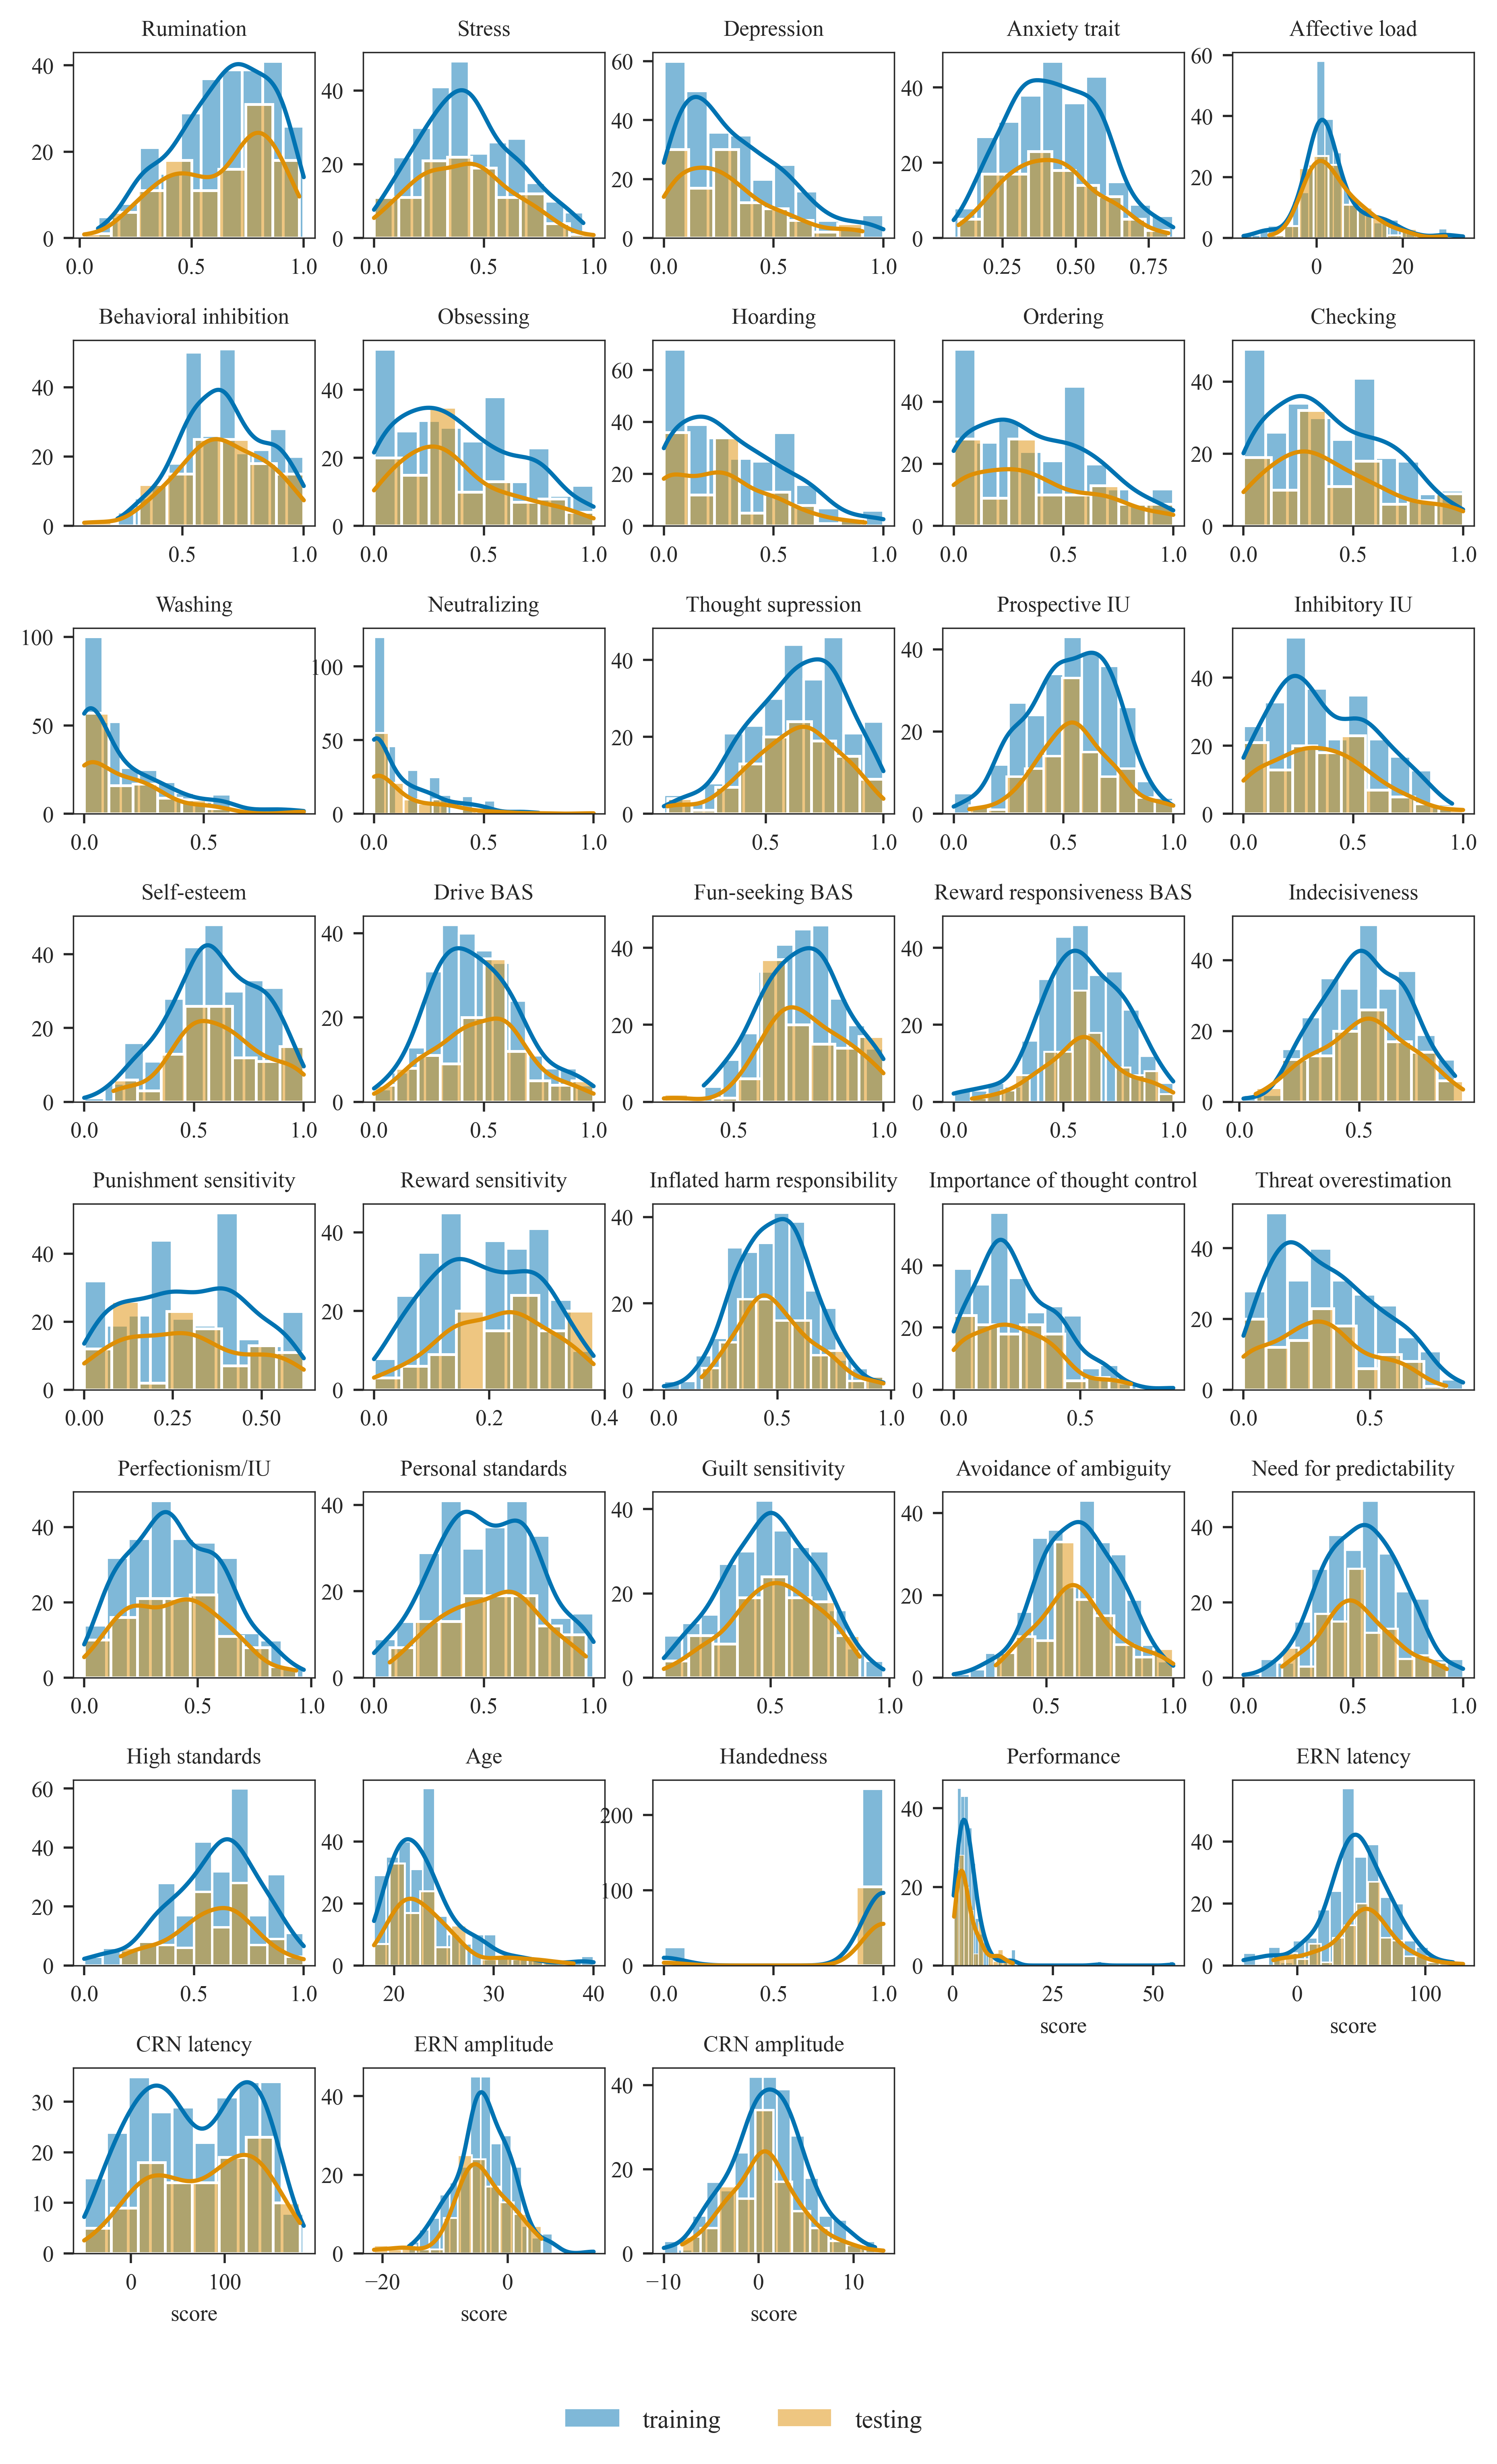

In [156]:
order = ['Rumination', 'Stress', 'Depression', 'Anxiety trait', 'Affective load', 'Behavioral inhibition', 'Obsessing', 'Hoarding' , 'Ordering', 'Checking', 'Washing', 
         'Neutralizing', 'Thought supression', 'Prospective IU', 'Inhibitory IU', 'Self-esteem', 'Drive BAS', 'Fun-seeking BAS', 'Reward responsiveness BAS', 'Indecisiveness',
        'Punishment sensitivity', 'Reward sensitivity', 'Inflated harm responsibility', 'Importance of thought control', 'Threat overestimation', 'Perfectionism/IU', 
        'Personal standards', 'Guilt sensitivity', 'Avoidance of ambiguity', 'Need for predictability', 'High standards', 'Age', 'Handedness', 'Performance', 'ERN latency', 
        'CRN latency', 'ERN amplitude', 'CRN amplitude']

sns.set_style("ticks")

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams["axes.linewidth"]  = 0.5

colors = [sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[1], 'gray']
sns.set_palette(colors)

# custom_palette = ["#4dac26",  '#d01c8b']
# sns.set_palette(custom_palette)
# sns.set_palette('colorblind')



g = sns.FacetGrid(
    variables_df_renamed, 
    col='scale', 
    col_wrap=5,
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5*cm,
    aspect= 1.5,
    # subplot_kws={"xlim":(0,1)},
    legend_out=False,
    hue='dataset',
    col_order=order,
)

g.map_dataframe(
    sns.histplot, 
    x="score",
    kde=True,
    cbar_kws={'saturation':0.9}
)

g.add_legend()

fig = g.fig
fig.set_size_inches(19*cm, 30*cm)

g.fig.subplots_adjust(wspace=.2, hspace=.55)
g.set_ylabels(label=None, clear_inner=True)
g.set_titles(template="{col_name}")

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, -0.04), ncol=2, title=None, frameon=False,
)
plt.setp(g._legend.get_texts(), fontsize=9)

plt.show()
fig.savefig(f'../data/scales_density/train_test_scales_density', bbox_inches='tight', pad_inches=0.01)

## Demographical data of the whole sample

In [186]:
opus_demo_df =  pd.read_csv('../data/scales/all_scales_with_rt.csv')
sonata_demo_df = pd.read_csv('../data/scales/Sonata_scales.csv', dtype={'Demo_kod': object})

In [185]:
opus_demo_df.shape

(174, 176)

Gender

In [75]:
display(opus_demo_df.groupby('Płeć').describe())
display(sonata_demo_df.groupby('Płeć').describe())

Pula badań                                              Ręczność  \
          count      mean       std  min  25%  50%  75%  max    count   
Płeć                                                                    
0         123.0  1.593496  0.493190  1.0  1.0  2.0  2.0  2.0    123.0   
1          51.0  1.529412  0.504101  1.0  1.0  2.0  2.0  2.0     51.0   

                ... mean Post-Error RT minus mean Post-Hit RT            \
          mean  ...                                       75%       max   
Płeć            ...                                                       
0     0.967480  ...                                  0.040557  0.219022   
1     0.882353  ...                                  0.043905  0.118356   

     mean Post-Error RT minus mean Post-Inhibited Response            \
                                                     count      mean   
Płeć                                                                   
0                                                 115.0     0.013483   
1                                                  48.0     0.008119   

                                                                  
           std       min       25%       50%       75%       max  
Płeć                                                              
0     0.044709 -0.063398 -0.012985  0.005340  0.030522  0.216527  
1     0.027369 -0.053965 -0.005873  0.003834  0.027567  0.077318  

[2 rows x 1344 columns]

Demo_kod                                                     \
                    count        mean        std    min    25%    50%    75%   
Płeć                                                                           
0                   113.0  108.734513  80.056009    0.0   31.0   98.0  192.0   
1                   111.0  115.234234  45.619963   11.0   77.5  113.0  149.5   
Osoba niebinarna      1.0  122.000000        NaN  122.0  122.0  122.0  122.0   

                        Ręczność            ... Thought Suppression Inventory  \
                    max    count      mean  ...                           75%   
Płeć                                        ...                                 
0                 223.0    113.0  0.929204  ...                      4.333333   
1                 224.0    111.0  0.864865  ...                      3.933333   
Osoba niebinarna  122.0      1.0  1.000000  ...                      4.466667   

                           Guilt sensitivity                                \
                       max             count      mean       std  min  25%   
Płeć                                                                         
0                 5.000000             113.0  3.176991  0.750596  1.5  2.6   
1                 5.000000             111.0  2.752252  0.709910  1.2  2.3   
Osoba niebinarna  4.466667               1.0  3.700000       NaN  3.7  3.7   

                                  
                  50%   75%  max  
Płeć                              
0                 3.1  3.70  4.9  
1                 2.9  3.25  4.5  
Osoba niebinarna  3.7  3.70  3.7  

[3 rows x 816 columns]

Age

In [76]:
age_df = pd.concat([opus_demo_df[['Wiek']], sonata_demo_df[['Wiek']]], ignore_index=True)
display(age_df.describe())

,Wiek
count,399.000000
mean,23.255639
std,3.946223
min,18.000000
25%,21.000000
50%,22.000000
75%,25.000000
max,40.000000


Education

In [77]:
edu_df = pd.concat([opus_demo_df[['Dotychczasowa liczba lat edukacji']], sonata_demo_df[['Twoja dotychczasowa liczba lat edukacji (w pełnych latach)']]], ignore_index=True)
display(edu_df.describe())

,Twoja dotychczasowa liczba lat edukacji (w pełnych latach)
count,225.000000
mean,15.413333
std,2.400298
min,9.000000
25%,14.000000
50%,15.000000
75%,17.000000
max,25.000000


#### Opus rejected individuals

In [34]:
opus_q_ids = pd.read_csv('../data/scales/all_scales_with_rt.csv',dtype={'Demo_kod': object})['Demo_kod'].to_numpy()
opus_q_ids

array(['AA0303', 'AB0601', 'AB0612', 'AC2011', 'AD1308', 'AD2711',
       'AD2906', 'AF0910', 'AG1208', 'AG1511', 'AI2201', 'AK0101',
       'AK0105', 'AK1312', 'AK1507', 'AK2012', 'AK2308', 'AL0402',
       'AN2907', 'AO2010', 'AO2601', 'AP0601', 'AP0706', 'AP2105',
       'AR0607', 'AR1506', 'AS0112', 'AS0401', 'AS0705', 'AS0802',
       'AS0805', 'AS2008', 'AS2303', 'AW0402', 'AW0601', 'AW0803',
       'AW2504', 'AZ1807', 'BB1406', 'BG0805', 'BK0504', 'BW1003',
       'BZ1004', 'BZ1405', 'DG1409', 'DJ0205', 'DK0105', 'DK1709',
       'DM0809', 'DO0607', 'DP1905', 'DP2803', 'DP2901', 'EK1909',
       'FK0508', 'FR0905', 'GP3001', 'GS1110', 'GW1704', 'HN2708',
       'HP0806', 'IA2105', 'IB1704', 'IG0308', 'IS0103', 'JA2905',
       'JF2307', 'JG0702', 'JK0204', 'JK2908', 'JL2111', 'JM0103',
       'JM0308', 'JM2103', 'JM2401', 'JM3011', 'JP1201', 'JS0303',
       'JW1005', 'JZ0904', 'KA0606', 'KB0101', 'KB2309', 'KD1102',
       'KG2901', 'KI1205', 'KJ1507', 'KJ1811', 'KJ2906', 'KK01

In [35]:
dir_ = '../data/responses_100_600/'
opus_eeg_ids = []

for file in sorted(glob.glob(dir_ + "*.vhdr")):
    re_match = re.search('GNG_(.*)-64', file)
    id_ = re_match.groups()[0]
    opus_eeg_ids.append(id_)
opus_eeg_ids = np.array(opus_eeg_ids)

In [36]:
opus_eeg_ids

array(['AA0303', 'AB0601', 'AB0612', 'AC2011', 'AD1308', 'AD2711',
       'AD2906', 'AF0910', 'AG1208', 'AG1511', 'AI2201', 'AK0101',
       'AK0105', 'AK1312', 'AK1507', 'AK2012', 'AK2308', 'AL0402',
       'AN2907', 'AO2010', 'AO2601', 'AP0601', 'AP0706', 'AP2105',
       'AR0607', 'AR1506', 'AS0112', 'AS0401', 'AS0802', 'AS0805',
       'AS2008', 'AS2303', 'AW0402', 'AW0601', 'AW0803', 'AW2504',
       'BB1406', 'BG0805', 'BK0504', 'BW1003', 'BZ1004', 'BZ1405',
       'DG1409', 'DJ0205', 'DK0105', 'DK1709', 'DM0809', 'DO0607',
       'DP1905', 'DP2803', 'DP2901', 'EK1909', 'FK0508', 'GP3001',
       'GS1110', 'GW1704', 'HN2708', 'HP0806', 'IA2105', 'IB1704',
       'IG0308', 'IS0103', 'JA2905', 'JF2307', 'JG0702', 'JK2908',
       'JL2111', 'JM0103', 'JM0308', 'JM2103', 'JM3011', 'JP1201',
       'JS0303', 'JW1005', 'JZ0904', 'KA0606', 'KB0101', 'KB2309',
       'KD1102', 'KG2901', 'KI1205', 'KJ1811', 'KJ2906', 'KK0110',
       'KK0903', 'KK1110', 'KM0312', 'KM2404', 'KN1606', 'KN27

In [37]:
list(set(opus_q_ids).difference(opus_eeg_ids))

['ML3006',
 'FR0905',
 'MŚ0905',
 'JM2401',
 'SH3110',
 'AS0705',
 'AZ1807',
 'JK0204',
 'MZ2212',
 'MŚ1705',
 'KJ1507']

#### Sonata rejected individuals

In [38]:
sonata_q_ids = pd.read_csv('../data/scales/Sonata_scales.csv', dtype={'Demo_kod': object})['Demo_kod'].to_numpy()
sonata_q_ids

array(['000', '001', '002', '003', '004', '005', '006', '007', '008',
       '009', '010', '011', '012', '013', '014', '015', '016', '017',
       '018', '019', '020', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031', '032', '033', '034', '035',
       '036', '037', '038', '039', '040', '041', '042', '043', '044',
       '045', '046', '047', '048', '049', '050', '051', '052', '053',
       '054', '055', '056', '057', '058', '059', '060', '061', '062',
       '063', '064', '065', '066', '067', '068', '069', '070', '071',
       '072', '073', '074', '075', '076', '077', '078', '079', '080',
       '081', '082', '083', '084', '085', '086', '087', '088', '089',
       '090', '091', '092', '093', '094', '095', '096', '097', '098',
       '099', '100', '101', '102', '103', '104', '105', '106', '107',
       '108', '109', '110', '111', '112', '113', '114', '115', '116',
       '117', '118', '119', '120', '121', '122', '123', '124', '125',
       '126', '127',

In [39]:
dir_ = '../data/responses_100_600_sonata/'
sonata_eeg_ids = []

for file in sorted(glob.glob(dir_ + "*.vhdr")):
    re_match = re.search('.*-GNG-(.*)_', file)
    id_ = re_match.groups()[0]
    sonata_eeg_ids.append(id_)
sonata_eeg_ids = np.array(sonata_eeg_ids)

In [40]:
sonata_eeg_ids

array(['000', '012', '014', '037', '041', '043', '044', '050', '053',
       '054', '055', '061', '067', '068', '076', '085', '087', '090',
       '091', '092', '095', '096', '097', '105', '106', '107', '109',
       '110', '114', '115', '118', '120', '121', '122', '127', '130',
       '131', '133', '139', '140', '142', '144', '145', '147', '148',
       '152', '155', '156', '157', '158', '170', '177', '180', '181',
       '182', '183', '184', '185', '186', '190', '194', '195', '197',
       '198', '201', '202', '204', '210', '211', '212', '213', '218',
       '219', '222', '223', '224', '001', '002', '003', '004', '006',
       '007', '008', '009', '010', '011', '013', '015', '016', '017',
       '018', '019', '020', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031', '032', '033', '034', '035',
       '036', '038', '039', '040', '042', '045', '046', '047', '048',
       '049', '051', '052', '056', '057', '058', '059', '060', '062',
       '063', '064',

In [41]:
list(set(sonata_q_ids).difference(sonata_eeg_ids))

['005', '075']

## Demo infos about loaded sample

In [107]:
ids = ID_train_list + ID_test_list

In [108]:
opus_edu_df = opus_demo_df[['Dotychczasowa liczba lat edukacji', 'Demo_kod']].rename(columns={'Dotychczasowa liczba lat edukacji': 'Education'})
sonata_edu_df = sonata_demo_df[['Twoja dotychczasowa liczba lat edukacji (w pełnych latach)', 'Demo_kod']].rename(columns={'Twoja dotychczasowa liczba lat edukacji (w pełnych latach)': 'Education'})

edu_df = pd.concat([opus_edu_df, sonata_edu_df], ignore_index=True)
edu_loaded_sample_df = edu_df[edu_df['Demo_kod'].isin(ids)]

In [110]:
edu_loaded_sample_df['Education'].iloc[47] = 13.5
edu_loaded_sample_df['Education'] = pd.to_numeric(edu_loaded_sample_df['Education'])
edu_loaded_sample_df.describe()

,Education
count,372.000000
mean,15.305108
std,2.468191
min,5.000000
25%,14.000000
50%,15.000000
75%,17.000000
max,25.000000


---

In [48]:
sample_ids = data_df['ID'].to_numpy()

In [49]:
full_readed_id = np.concatenate([sonata_eeg_ids, opus_eeg_ids])
full_readed_id

array(['000', '012', '014', '037', '041', '043', '044', '050', '053',
       '054', '055', '061', '067', '068', '076', '085', '087', '090',
       '091', '092', '095', '096', '097', '105', '106', '107', '109',
       '110', '114', '115', '118', '120', '121', '122', '127', '130',
       '131', '133', '139', '140', '142', '144', '145', '147', '148',
       '152', '155', '156', '157', '158', '170', '177', '180', '181',
       '182', '183', '184', '185', '186', '190', '194', '195', '197',
       '198', '201', '202', '204', '210', '211', '212', '213', '218',
       '219', '222', '223', '224', '001', '002', '003', '004', '006',
       '007', '008', '009', '010', '011', '013', '015', '016', '017',
       '018', '019', '020', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031', '032', '033', '034', '035',
       '036', '038', '039', '040', '042', '045', '046', '047', '048',
       '049', '051', '052', '056', '057', '058', '059', '060', '062',
       '063', '064',

In [50]:
list(set(full_readed_id).difference(sample_ids))

['MP0701',
 'DP2803',
 '002',
 'KD1102',
 '126',
 '030',
 'AK1507',
 'PM0209',
 'PS1511',
 'PZ0310',
 'BG0805',
 '146',
 '045',
 '173']

sonata: 146, 030, 126, 002

opus: MP0701, DP2803, KD1102, AK1507, PM0209, PS1511, PZ0310, BG0805